<br><br>
<p style="font-size:24px; color:#216594;text-align:center;">
Applied AI in Chemical and Process Engineering
</p>

<p style="font-size:30px; color:black;text-align:center;">
    Bulding ML pipeline for Reactor data
</p>


███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
<br>


**Week 3-4**

This notebook will build a pipeline to prepare data and develop an ML algorithm


# Content

**Part 1: Data Preprocessing & Exploration**

| Step                  | Description                                                                 | Key Actions & Tools                                                                                     |
|-----------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **Data Preparation**  | Gather, load, and inspect raw data                                          | - Load dataset (e.g., CSV, DB)<br>- Check data types, shape, initial samples (`df.head()`, `df.info()`) |
| **Data Cleaning**     | Fix issues in data quality                                                  | - Handle missing values (impute or drop)<br>- Remove duplicates<br>- Detect and treat outliers (IQR, Z-score) |
| **Exploratory Data Analysis (EDA)** | Understand data distributions and relationships                   | - Visualizations: histograms, scatter plots, pair plots<br>- Correlation matrix (heatmaps)<br>- Summary statistics |

**Part 2: Modeling & Interpretation**

| Step                                  | Description                                                                 | Key Actions & Tools                                                                                     |
|---------------------------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **Normalization (Principle Only)**    | Scale features to same range (e.g., for distance-based models)              | - Apply Min-Max Scaling or Standardization<br>- Justify choice based on model needs (e.g., SVM, KNN, Neural Networks) |
| **Model Training, Validation & Testing** | Build and evaluate model performance                                    | - Split data: `train_test_split`<br>- Train models (e.g., Linear Regression, Random Forest, XGBoost)<br>- Use cross-validation<br>- Evaluate using metrics (RMSE, MAE, R², etc.) |
| **Model Explanation with XAI**        | Interpret model predictions and feature importance                          | - Use SHAP, LIME, or feature importance plots<br>- Explain predictions to stakeholders<br>- Ensure transparency and trust |

**Note:** Since our example does not have categorical data, we do not encode variables - which is essential if the data is categorical

# Ethanol Production - Sugar Industry

![Process Flow Diagram](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/etoh_flowdiagram.png?raw=1)


**Our goal is to model residual sugar. The model can be later used to optimize the fermentation process**

**Data**
- Temperature °C: Fermentation tank
- pH: Fermentation tank
- Yeast Concentration g/L: Fermentation tank
- Sugar Concentration w/v: Dilution tank (input for fermenation)
- Residual Sugar g/L: Post-fermentation


Note: The data is simualted data


In [10]:
# Load all the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.optimize import minimize
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'xgboost'

# Data Preperation

**Prompt:**
Load data from below github
https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/Ethanol_Molasses_Dataset.csv


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/Ethanol_Molasses_Dataset.csv')

**Prompt:**

Print first 15 rows of the table and the dimensions of the table

In [ ]:
# Print first 15 rows of the table
print("First 15 rows of the table:")
df.head(15)


First 15 rows of the table:


,Temperature,pH,Yeast_Concentration,Sugar_Concentration,Residual_Sugar
0,28.7,5.0,1.2,12.3,5.3
1,34.5,5.4,2.3,10.0,5.4
2,32.3,5.1,4.1,17.3,3.2
3,31.0,4.3,3.8,19.7,2.7
4,26.6,4.0,4.2,12.2,5.5
5,26.6,4.4,3.1,16.6,5.2
6,25.6,4.9,2.8,17.4,5.2
7,33.7,4.1,1.6,18.5,7.6
8,31.0,4.7,2.3,14.2,5.1
9,32.1,4.9,2.7,13.0,3.9


In [ ]:
# Print the shape of the table
print("Shape of the table (rows, columns):")
print(df.shape)

Shape of the table (rows, columns):
(972, 5)


# Data Cleaning

| Step           | Purpose                                      | Common Methods                                                                 | Notes                                                                 |
|----------------|----------------------------------------------|---------------------------------------------------------------------------------|-----------------------------------------------------------------------|
| **Missing Data** | Handle incomplete or null values             | - Remove rows/columns<br>- Impute with mean/median/mode<br>- KNN/imputation models | Can bias models; choice depends on amount and reason for missingness |
| **Duplicates**   | Remove redundant data entries                | - Identify and drop duplicate rows<br>- Use `pandas.drop_duplicates()`           | Prevents overfitting and skewed results                              |
| **Outliers**     | Detect and manage extreme values             | - Z-score, IQR method<br>- Visualization (box plots, scatter plots)<br>- Winsorizing | Can distort models; keep if meaningful (e.g., fraud detection)       |

## Check for missing data

**Prompt:**
Check if the table has missing values

In [ ]:
# Check for missing values in the entire DataFrame
print("Total number of missing values in the table:")
print(df.isnull().sum().sum())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nSummary: Does the table have any missing values?")
print(df.isnull().values.any())

Total number of missing values in the table:
2

Missing values per column:
Temperature            0
pH                     0
Yeast_Concentration    0
Sugar_Concentration    2
Residual_Sugar         0
dtype: int64

Summary: Does the table have any missing values?
True


## Fill the missing data wiht median using imputer

**Prompt:**
Fill the missing data with median value

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Identify numeric columns with missing values
# From your data: Sugar_Concentration and Ethanol_Yield have 2 missing values each
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Create a SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Fit and transform the numeric columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Verify that all missing values are filled
print("Missing values after imputation:")
print(df.isnull().sum())

print(f"\nImputation completed using median values.")

Missing values after imputation:
Temperature            0
pH                     0
Yeast_Concentration    0
Sugar_Concentration    0
Residual_Sugar         0
dtype: int64

Imputation completed using median values.


## Check for duplicates

**Prompt:**

Check if it has duplicates

In [ ]:
# Check for duplicate rows
print("Number of duplicate rows in the DataFrame:")
print(df.duplicated().sum())

print("\nWhich rows are duplicates?")
print(df[df.duplicated()])

Number of duplicate rows in the DataFrame:
0

Which rows are duplicates?
Empty DataFrame
Columns: [Temperature, pH, Yeast_Concentration, Sugar_Concentration, Residual_Sugar]
Index: []


# Exploratory Dara Analysis (EDA)

## Summary Stats

**Prompt:**

In [ ]:
df.describe()

,Temperature,pH,Yeast_Concentration,Sugar_Concentration,Residual_Sugar
count,972.000000,972.000000,972.000000,972.000000,972.000000
mean,30.003807,4.760802,2.982510,14.961934,5.155041
std,3.649713,0.484015,1.160695,2.852478,1.510385
min,25.000000,0.100000,1.000000,10.000000,0.800000
25%,27.375000,4.400000,2.000000,12.500000,4.100000
50%,30.000000,4.800000,3.000000,14.950000,5.200000
75%,32.500000,5.100000,4.000000,17.400000,6.100000
max,82.000000,9.000000,5.000000,20.000000,10.900000


## Data Visualization

### Data Visualization with Box Plot


![Box plot](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/boxplot.png?raw=1)

**Prompt:**

Create box plots for all variables in multiple plots in single figure. show outliers

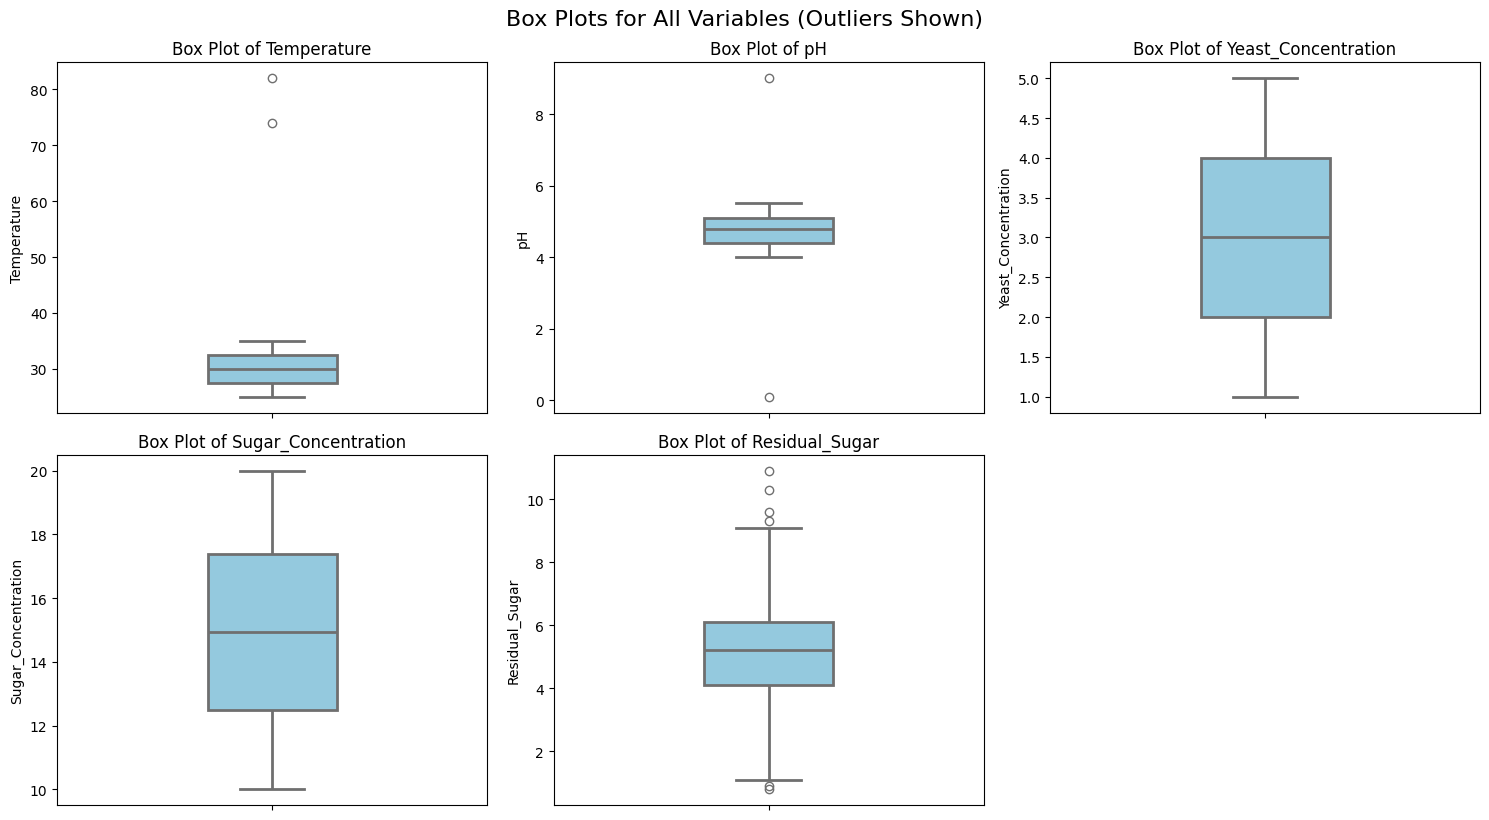

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplot grid (adjust layout based on number of variables)
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Adjust rows to have up to 3 plots per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of multiple rows

# Create a box plot for each numeric variable
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue', fliersize=6, linewidth=2, width=.3)
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_ylabel(col, fontsize=10)

# Hide any unused subplots
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Box Plots for All Variables (Outliers Shown)', fontsize=16, y=1.02)
plt.show()

### Data Visualization with Violine plot


![Violin plot](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/violinplot.png?raw=1)

**Prompt:**

Create violine plots for all variables in multiple plots in single figure.

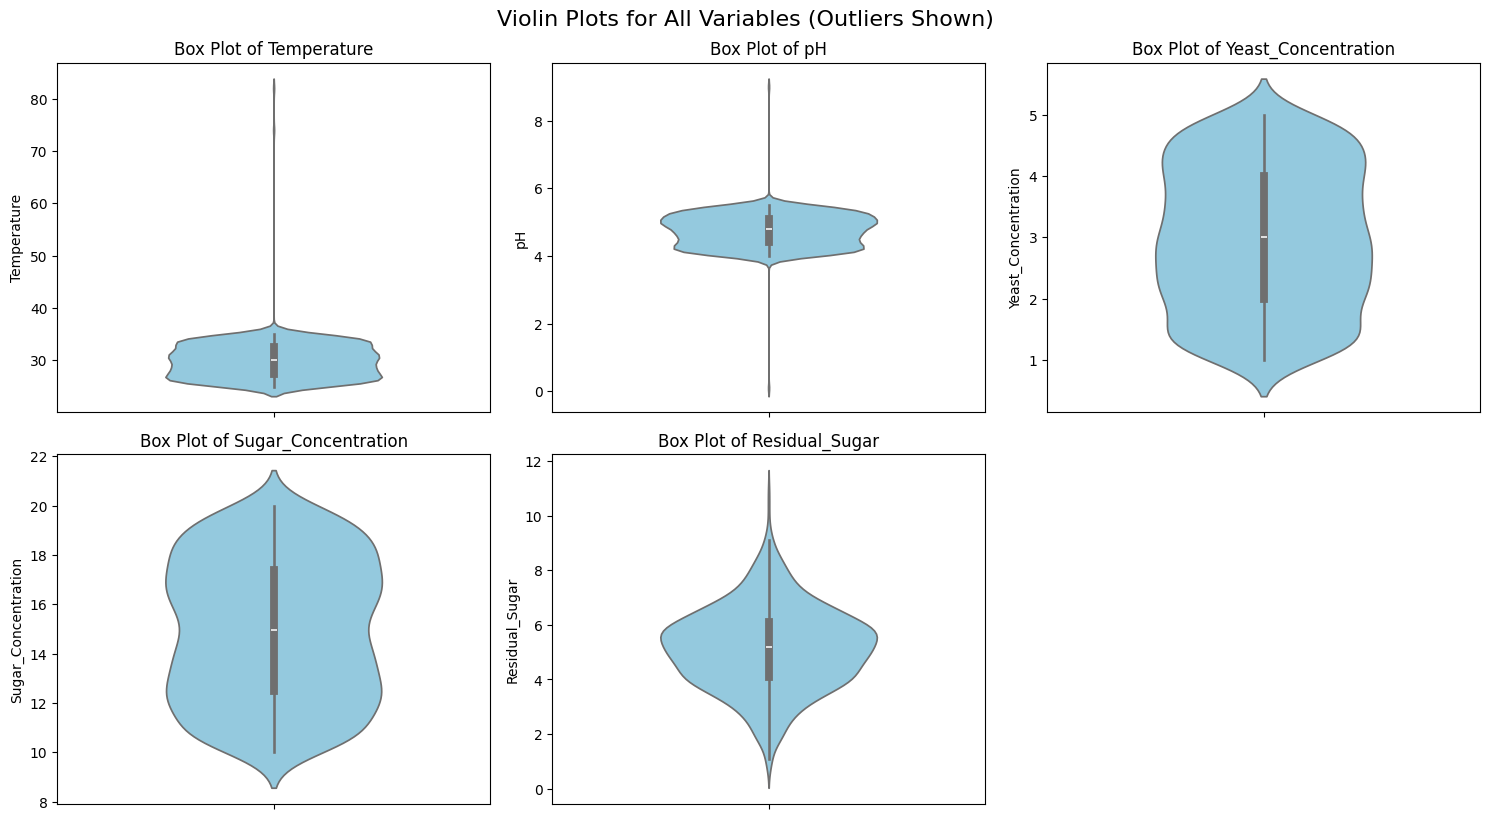

In [ ]:
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Adjust rows to have up to 3 plots per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of multiple rows

# Create a box plot for each numeric variable
for i, col in enumerate(numeric_cols):
    sns.violinplot(y=df[col], ax=axes[i], color='skyblue', width=.5)
    axes[i].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i].set_ylabel(col, fontsize=10)

# Hide any unused subplots
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Violin Plots for All Variables (Outliers Shown)', fontsize=16, y=1.02)
plt.show()

### Data Visualization with Histogram plot

**Prompt:**

Create histogram plots for all variables in multiple plots in single figure.

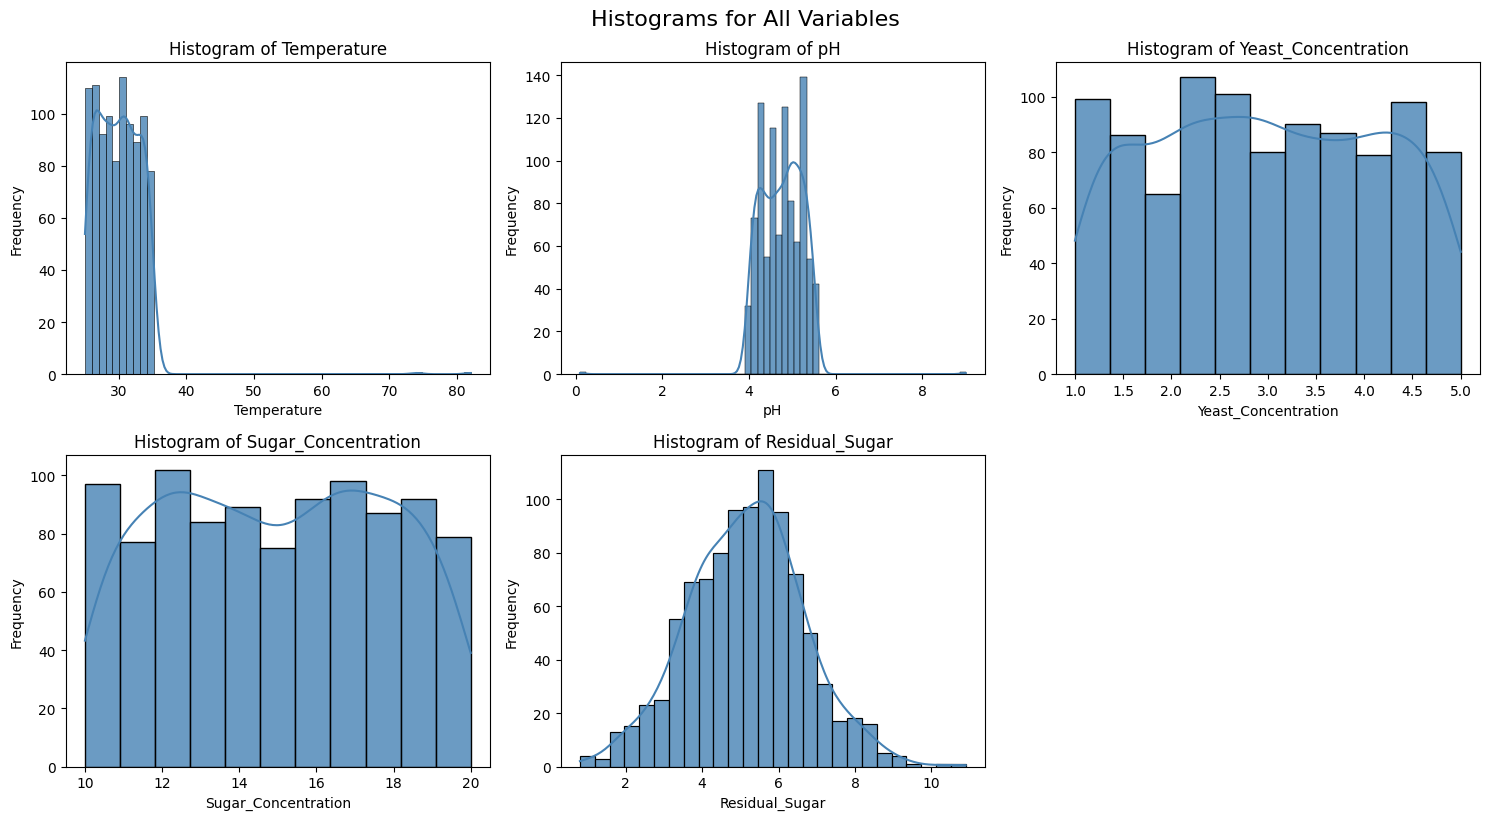

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplot grid (e.g., 3 plots per row)
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Ceiling division to get number of rows
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot histogram for each numeric variable
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='steelblue', alpha=0.8)
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Hide any unused subplots
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms for All Variables', fontsize=16, y=1.02)
plt.show()

## Outliers

**Strategy:** We will use statistical methods to remove outliers (IQR)

**Prompt:**

Remove all outliers of df using IQR method and create a table called dfclean

Original DataFrame (numeric rows): 972
Cleaned DataFrame (dfclean): 964
Outliers removed: 8 rows
Reduction: 0.82%


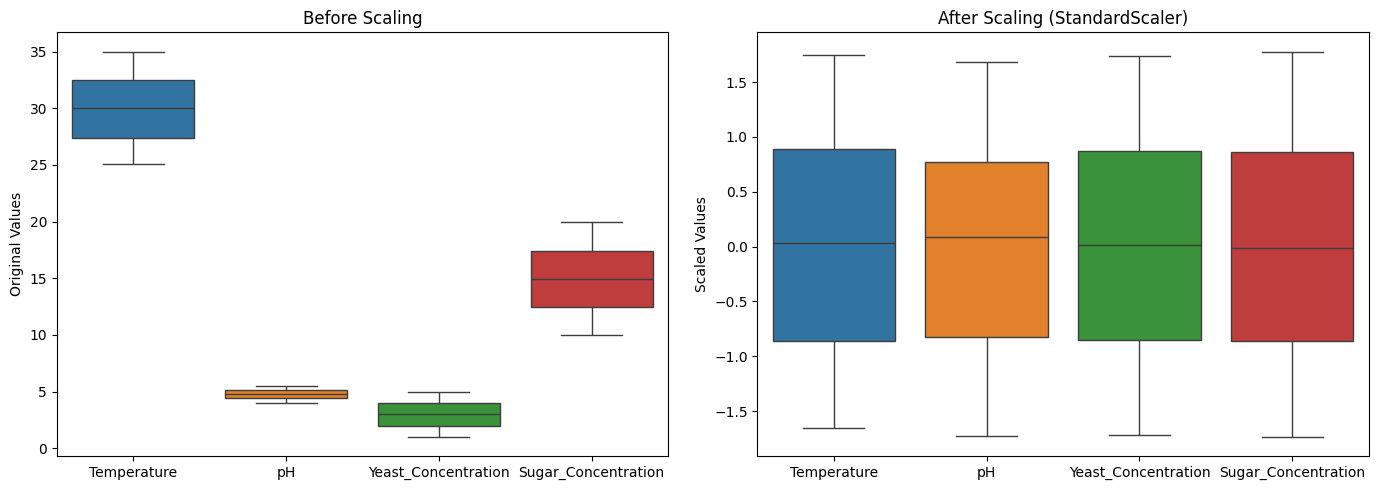

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/refs/heads/main/data/Ethanol_Molasses_Dataset.csv')
# Step 1: Select only numeric columns from df
df_numeric = df.select_dtypes(include=[np.number])

# Step 2: Define function to remove outliers using IQR
def remove_outliers_iqr(df, factor=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    # Create a mask for non-outlier values
    mask = (df >= lower_bound) & (df <= upper_bound)
    # Keep only rows where all columns are within bounds
    return df[mask.all(axis=1)]

# Step 3: Apply IQR method and create dfclean
dfclean = remove_outliers_iqr(df_numeric)

# Step 4: Optional – Reset index for cleanliness
dfclean = dfclean.reset_index(drop=True)

# Step 5: Print summary
print(f"Original DataFrame (numeric rows): {df_numeric.shape[0]}")
print(f"Cleaned DataFrame (dfclean): {dfclean.shape[0]}")
print(f"Outliers removed: {df_numeric.shape[0] - dfclean.shape[0]} rows")
print(f"Reduction: {((df_numeric.shape[0] - dfclean.shape[0]) / df_numeric.shape[0] * 100):.2f}%")



#-------------------------------------------------------------------SCALING-------------------------------------------------------------------#


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select features (same as before)
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']
X = dfclean[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Before scaling ---
sns.boxplot(data=X, ax=axes[0])
axes[0].set_title("Before Scaling")
axes[0].set_ylabel("Original Values")

# --- After scaling ---
sns.boxplot(data=X_scaled_df, ax=axes[1])
axes[1].set_title("After Scaling (StandardScaler)")
axes[1].set_ylabel("Scaled Values")

plt.tight_layout()
plt.show()


### Histogram plot with cleaned data

**Prompt:**

Create histogram plots for all variables in multiple plots in single figure using dfclean

Text(0.5, 1.02, 'Histograms for All Variables (dfclean - Outliers Removed)')

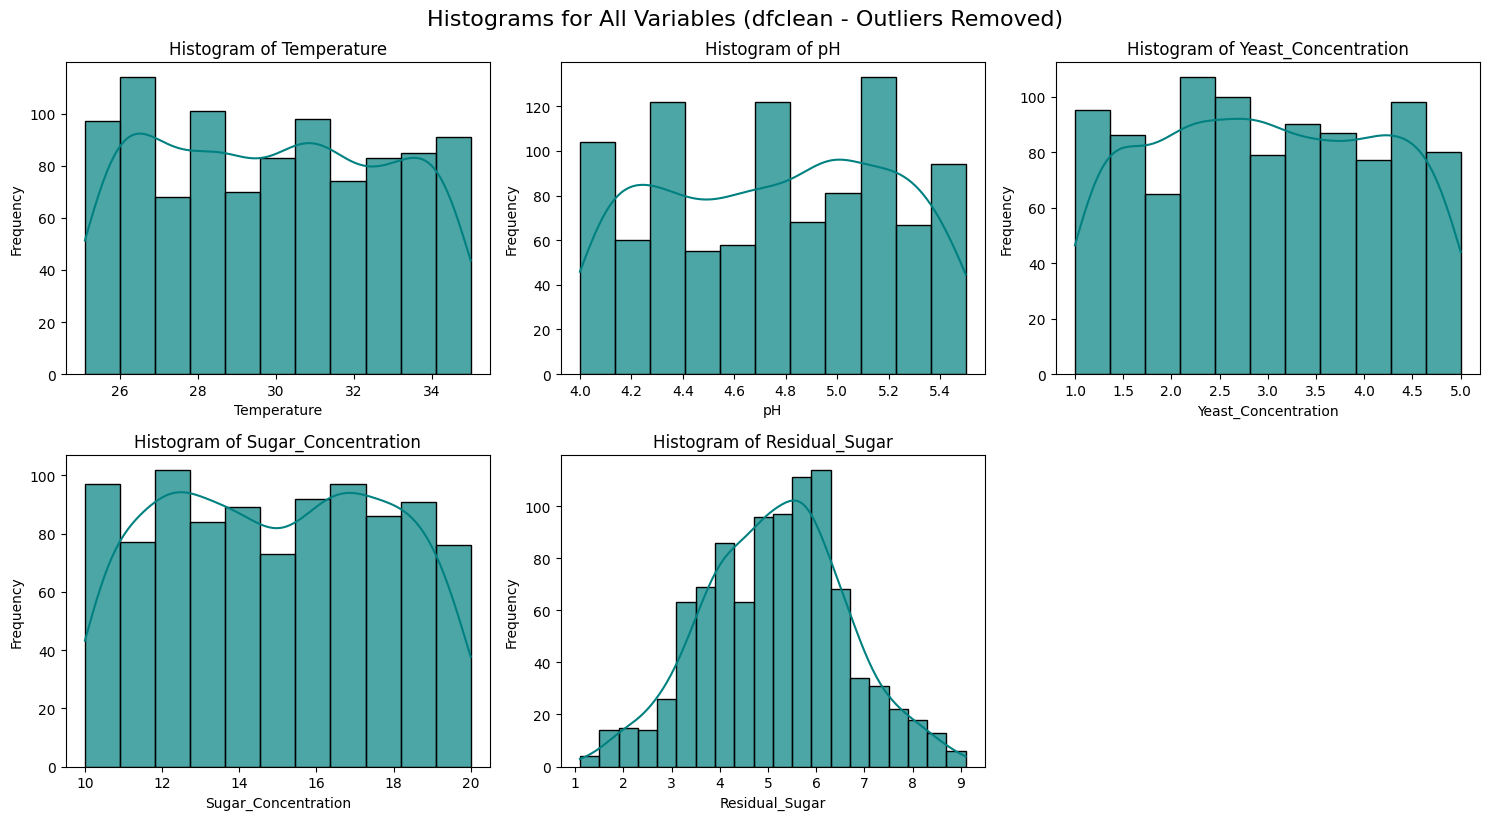

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric columns from dfclean (safe if mixed types)
numeric_cols = dfclean.select_dtypes(include=[np.number]).columns

# Set up the subplot grid (e.g., 3 plots per row)
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # Ceiling division to determine number of rows
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten for easy indexing

# Plot histogram for each numeric column in dfclean
for i, col in enumerate(numeric_cols):
    sns.histplot(dfclean[col], ax=axes[i], kde=True, color='teal', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Hide any unused subplots (if total plots > number of variables)
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms for All Variables (dfclean - Outliers Removed)', fontsize=16, y=1.02)

## Corelinearity

**Prompt:**

Print correlations matrix and do a plot a heatmap of correlation of dfclean

=== Correlation Matrix ===
                     Temperature        pH  Yeast_Concentration  \
Temperature             1.000000 -0.012451            -0.008779   
pH                     -0.012451  1.000000             0.015833   
Yeast_Concentration    -0.008779  0.015833             1.000000   
Sugar_Concentration    -0.014722  0.003738             0.006277   
Residual_Sugar         -0.011687 -0.026576            -0.510320   

                     Sugar_Concentration  Residual_Sugar  
Temperature                    -0.014722       -0.011687  
pH                              0.003738       -0.026576  
Yeast_Concentration             0.006277       -0.510320  
Sugar_Concentration             1.000000        0.102366  
Residual_Sugar                  0.102366        1.000000  


<Axes: >

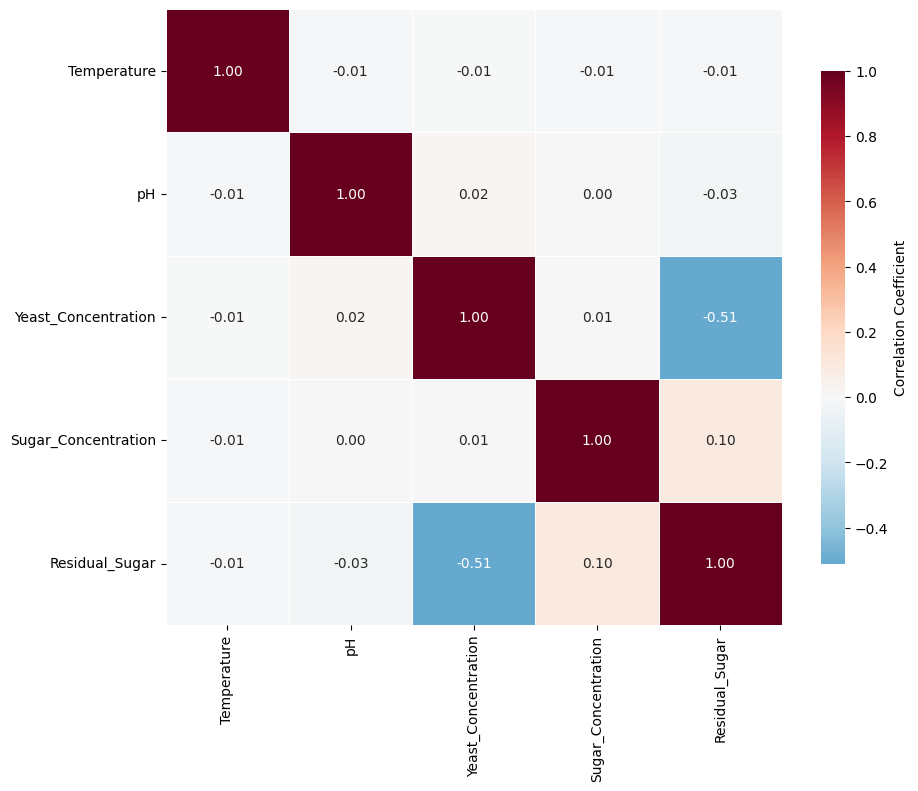

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure only numeric columns are used
df_numeric = dfclean.select_dtypes(include=[float, int])

# Step 1: Compute and print the correlation matrix
print("=== Correlation Matrix ===")
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

# Step 2: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,           # Show correlation values on the map
    cmap='RdBu_r',        # Red-Blue diverging colormap (good for -1 to 1)
    center=0,             # Center the colormap at zero
    square=True,          # Make cells appear square
    fmt='.2f',            # Format numbers to 2 decimal places
    linewidths=0.5,       # Add thin lines between cells
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)

# Customize

1. **What the Correlation Matrix Means**

Each number shows the degree of linear relationship between two variables — in your case:
Temperature, pH, Yeast_Concentration, Sugar_Concentration, Residual_Sugar

| Value | Meaning                                                            |
| ----- | ------------------------------------------------------------------ |
| +1    | Perfect **positive** correlation (both rise/fall together)         |
| 0     | **No linear** correlation                                          |
| -1    | Perfect **negative** correlation (one rises while the other falls) |

2. **Interpreting Your Matrix**

Let’s go line by line through your table:

| Variable 1                                     | Variable 2 | Correlation                                                                                                             | Meaning |
| ---------------------------------------------- | ---------- | ----------------------------------------------------------------------------------------------------------------------- | ------- |
| **Temperature vs others**                      | All near 0 | → Temperature doesn’t seem correlated with pH, yeast, sugar, or residual sugar.                                         |         |
| **pH vs others**                               | All near 0 | → pH also seems independent — doesn’t affect or get affected by others in your dataset.                                 |         |
| **Yeast_Concentration vs Residual_Sugar**      | **-0.51**  | → Moderate **negative** correlation — as yeast increases, residual sugar decreases (makes sense: yeast consumes sugar). |         |
| **Sugar_Concentration vs Residual_Sugar**      | **0.10**   | → Very weak positive correlation — not significant.                                                                     |         |
| **Sugar_Concentration vs Yeast_Concentration** | 0.006      | → No real relation.                                                                                                     |         |

3. **Key Insights from This Matrix**

    1. No strong collinearity problem here — almost all correlations are small except one moderate one (-0.51).
    → That’s good news. It means your variables are mostly independent.

    2. The negative relationship between yeast concentration and residual sugar makes scientific sense:
    More yeast → more fermentation → less residual sugar.

    3. If you were training an AI model, this matrix tells you:
    You can safely keep all variables (no redundant information).
    Just be aware that yeast and residual sugar are somewhat inversely related.

4. **Why the Matrix is Symmetrical**

You’ll notice it’s mirrored:
The correlation between Temperature and pH is the same as between pH and Temperature.
The diagonal is always 1.0 — because every variable is perfectly correlated with itself.

5. **How to Read It Visually**

If you plot the heatmap:
Blue cells (positive) → both rise together.
Red cells (negative) → one rises while the other falls.
White/light cells → little to no relation.
So your heatmap would mostly look pale or neutral, except for a red-blue area between Yeast_Concentration and Residual_Sugar.

✅ *Summary for You (Chemical Engineering View):*

The matrix shows relationships between experiment variables.
You use it to detect if some variables are redundant or strongly dependent.
In your case, there’s no strong collinearity issue — only a meaningful, expected relationship (yeast ↔ sugar).

# Data Prep for Model

## Define Features and Target

**Prompt:**

'Residual_Sugar' is Y variables and Temperature','pH','Yeast_Concentration','Sugar_Concentration' are features. Plot scatter plot between features and Y

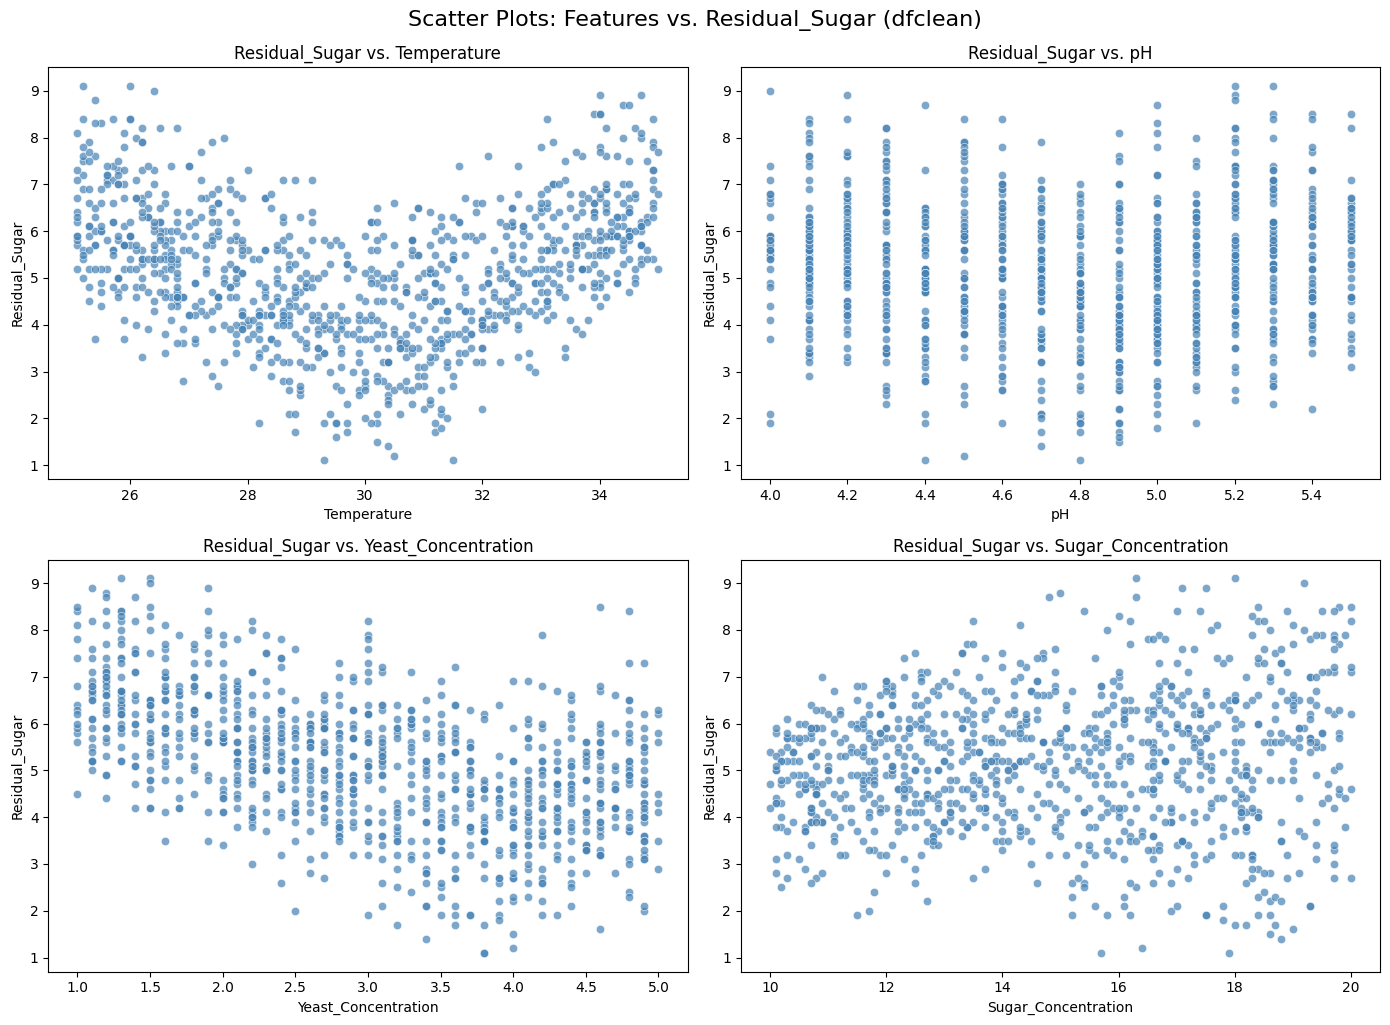

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define features and target
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']
target = 'Residual_Sugar'

# Select data from dfclean (assumed to be your cleaned DataFrame)
df_plot = dfclean  # Ensure dfclean is defined

# Set up the subplot: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Plot each feature vs. Residual_Sugar
for i, col in enumerate(features):
    sns.scatterplot(x=df_plot[col], y=df_plot[target], ax=axes[i], alpha=0.7, color='steelblue')
    axes[i].set_title(f'{target} vs. {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel(target, fontsize=10)

# Optional: Add a trend line (regression line) to each plot
# Uncomment the loop below if you want trend lines
"""
for i, col in enumerate(features):
    sns.regplot(x=df_plot[col], y=df_plot[target], ax=axes[i],
                scatter=False, color='red', line_kws={'linewidth': 1.5})
"""

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Scatter Plots: Features vs. Residual_Sugar (dfclean)', fontsize=16, y=1.02)
plt.show()

## Feature Engineering with Data Scaling (Demo)

**Prompt:**

Normalize X data using StandarScaler and plot histogram

### Normalization (Feature Scaling)

Normalization, also known as feature scaling, is a data preprocessing technique used to standardize the range of independent variables or features of a dataset. It is a crucial step in machine learning, especially for algorithms that are sensitive to the magnitude of input features, such as:

*   **Distance-based algorithms:** K-Nearest Neighbors (KNN), Support Vector Machines (SVM)
*   **Optimization algorithms:** Gradient Descent used in linear regression, logistic regression, and neural networks.

By scaling the features, we ensure that no single feature dominates the learning process simply because of its larger scale. This helps the model converge faster and often leads to better performance.

### StandardScaler

`StandardScaler` is a widely used technique for feature scaling. It standardizes features by removing the mean and scaling to unit variance. The formula for standardization is:

$z = (x - \mu) / \sigma$

where:
*   $x$ is the original feature value
*   $\mu$ is the mean of the feature values
*   $\sigma$ is the standard deviation of the feature values
*   $z$ is the scaled feature value

After standardization, the features will have a mean of 0 and a standard deviation of 1.

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define features and target
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']
target = 'Residual_Sugar'

# Separate features (X) and target (y)
# Assuming dfclean is already defined and contains your cleaned data
X = dfclean[features]
y = dfclean[target]


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features and transform the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame for easier plotting
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Print summary statistics for scaled data to show mean ~0 and std dev ~1
print("Summary statistics of scaled features:")
print(X_scaled_df.describe())

Summary statistics of scaled features:
        Temperature            pH  Yeast_Concentration  Sugar_Concentration
count  9.640000e+02  9.640000e+02         9.640000e+02         9.640000e+02
mean   3.427410e-16 -9.379312e-16        -3.685388e-17         5.491228e-16
std    1.000519e+00  1.000519e+00         1.000519e+00         1.000519e+00
min   -1.649969e+00 -1.731078e+00        -1.717996e+00        -1.734952e+00
25%   -8.616246e-01 -8.205560e-01        -8.538888e-01        -8.567629e-01
50%    2.954690e-02  8.996600e-02         1.021870e-02        -1.370121e-02
75%    8.864426e-01  7.728575e-01         8.743262e-01         8.644881e-01
max    1.743338e+00  1.683380e+00         1.738434e+00         1.777805e+00


You’ll see:
    mean ≈ 0
    std ≈ 1
confirming successful scaling.



| Concept                               | Formula                                        | Resulting Range   | When to Use                                                       |
| ------------------------------------- | ---------------------------------------------- | ----------------- | ----------------------------------------------------------------- |
| **Normalization (Min-Max Scaling)**   | $x' = (\frac{x - x_{min}}{x_{max} - x_{min}} )$ | 0 → 1             | When you know data has clear boundaries (e.g. pixel values 0–255) |
| **Standardization (Z-score Scaling)** | $z = (\frac{x - \mu}{\sigma} )$               | mean = 0, std = 1 | When data may not have a fixed range or has outliers              |


**Problem 1 — Unequal influence**

Models like Linear Regression, Logistic Regression, SVM, KNN, and Neural Networks use mathematical distances or gradients.
The feature with the largest numerical range dominates those computations.
👉 Example:
When calculating distance between samples (say in KNN or clustering),

`distance = sqrt(ΔTemp² + ΔpH² + ΔSugar² + ΔYeast²)`

If Sugar_Concentration ranges from 10–20, and pH ranges from 4–8,
then ΔSugar² contributes 100× more to the total distance — even if it’s not truly more important.
So the model ends up thinking sugar is the only thing that matters, just because it has big numbers.

**Problem 2 — Slow or unstable training (Gradient Descent)**

In models that learn via optimization (like regression or neural nets), the algorithm tries to minimize error by adjusting weights:

`weight_new = weight_old - learning_rate * gradient`

If one feature is 100x larger in scale, its gradient explodes,
causing zig-zagging or divergence instead of smooth convergence.
It’s like trying to walk downhill but one leg is 100x longer than the other.
👉 Result: the model takes much longer to train, or fails to converge properly.

**Problem 3 — Coefficient Misinterpretation**

In linear models, the coefficients (β values) become misleading:
Without scaling: a large coefficient might just mean “the feature has big numbers,” not “it’s more important.”
After scaling: all features are on equal footing, so you can compare coefficients fairly.

⚙️ What happens after feature engineering (with scaling)

After scaling (standardization or normalization):
| Feature             | Mean | Std | Range       |
| ------------------- | ---- | --- | ----------- |
| Temperature         | 0    | 1   | -1.7 → +1.7 |
| pH                  | 0    | 1   | -1.7 → +1.7 |
| Yeast_Concentration | 0    | 1   | -1.7 → +1.7 |
| Sugar_Concentration | 0    | 1   | -1.7 → +1.7 |

Now:

* All features contribute equally to distance or gradient calculations.
* The optimization landscape becomes smooth, so training stabilizes.
* The model learns true relationships, not numeric biases.
* Coefficients, loss, and accuracy all behave more predictably.

| Issue                    | Consequence                                            |
| ------------------------ | ------------------------------------------------------ |
| Unequal scales           | Model gives too much weight to one feature             |
| Gradient explosion       | Training becomes unstable or diverges                  |
| Slow learning            | Takes more epochs to converge                          |
| Wrong feature importance | Misleading conclusions about which variable matters    |
| Poor accuracy            | Because the model never learned the true relationships |

***Feature engineering = signal preparation.***

*Without it, your model listens to noise, not meaning.*

You can think of scaling like calibrating sensors before using them in a control system —
if one sensor outputs in volts and another in milliamps, your controller makes wrong decisions.
Scaling “calibrates” the data so the model can compare fairly.

🧠 *Intuitive Example*
If you have:
* Temperature = +2 → means 2σ above average (unusually hot)
* pH = –1 → means 1σ below average (a bit acidic)
* Yeast = 0 → means average yeast concentration

Now your model doesn’t care whether that’s 35°C or 8 pH — it only knows

“Temperature is 2× more extreme than pH deviation.”
Everything is dimensionless and comparable.

🔬 *So the “mean = 0 and std = 1” is not just math:*
It’s a reframing of your data — from raw units (°C, pH, g/L) to relative position (how far from normal).
That’s why ML models understand and optimize them much more efficiently.

### Histogram

A histogram is a graphical representation that shows the distribution of a dataset. It groups data into bins and displays the frequency or count of data points falling into each bin. Histograms are useful for understanding:

*   The shape of the data's distribution (e.g., normal, skewed)
*   The central tendency (mean, median)
*   The spread (variance, standard deviation)
*   The presence of outliers or multiple modes

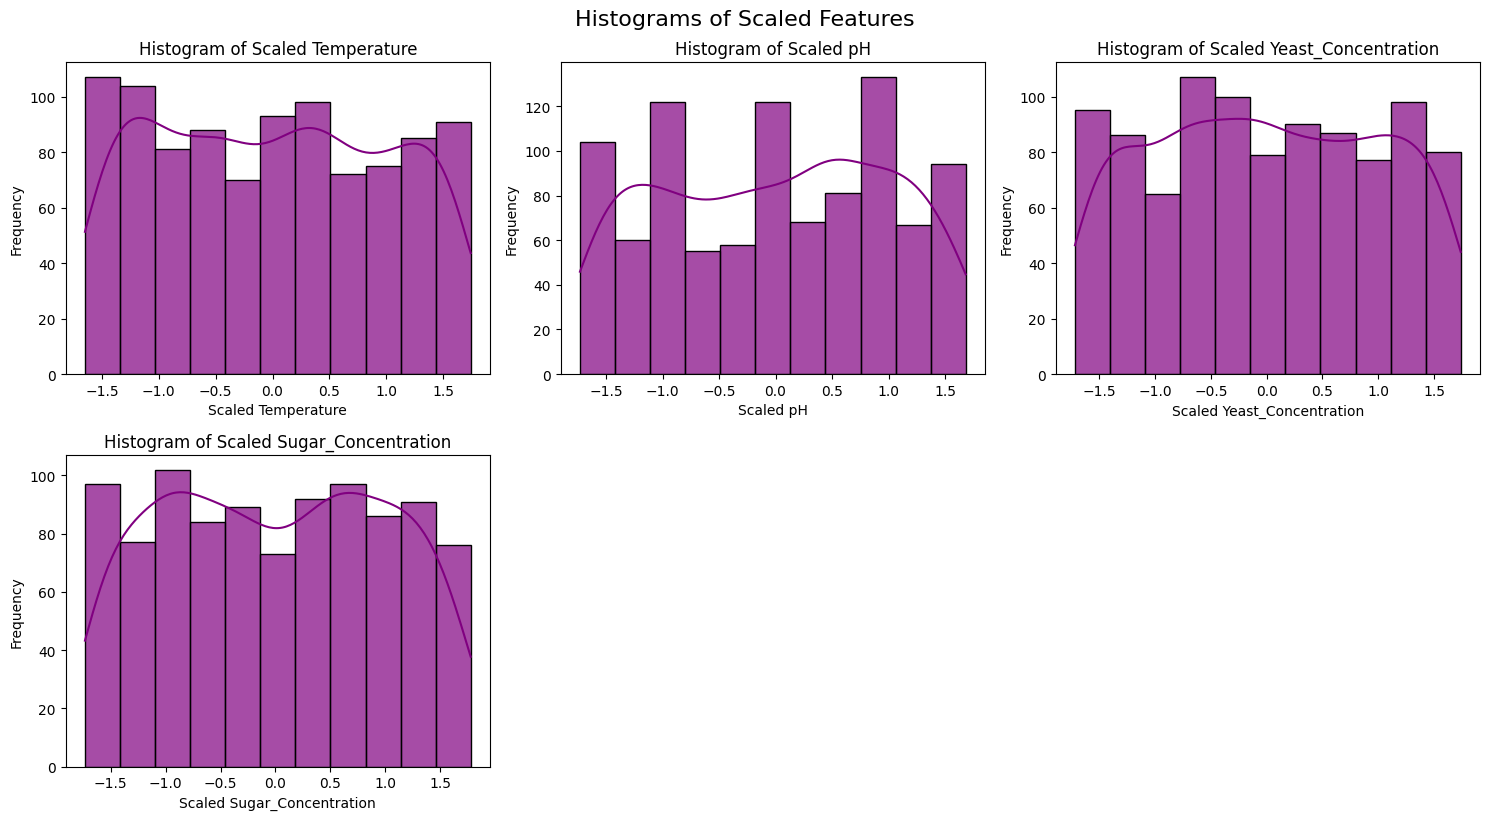

In [ ]:
# Set up the subplot grid (e.g., 3 plots per row)
n_cols = len(features)
n_rows = (n_cols + 2) // 3  # Ceiling division to determine number of rows
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten for easy indexing

# Plot histogram for each scaled feature
for i, col in enumerate(features):
    sns.histplot(X_scaled_df[col], ax=axes[i], kde=True, color='purple', alpha=0.7)
    axes[i].set_title(f'Histogram of Scaled {col}', fontsize=12)
    axes[i].set_xlabel(f'Scaled {col}', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Hide any unused subplots (if total plots > number of variables)
for i in range(i + 1, len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms of Scaled Features', fontsize=16, y=1.02)
plt.show()

# Model Selection


![Model guide](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/model_selection.png?raw=1)

# XGBoost Model


**Note:**

Since this is tree model which does not require feature scaling in general, we **will not** use scaled data for model fitting


<p style="font-size:25px; color:blue;text-align:left;">
    XGBoost - Extreme Gradient Boosting.
</p>


    🔘 XGBoost is a machine learning algorithm that builds multiple decision trees one after another, where each new tree tries to fix the errors made by the previous trees.

    🔘 It uses a method called gradient boosting, which helps improve prediction accuracy by combining many weak models into a stronger one.
    
    🔘The algorithm includes features to prevent overfitting, such as regularization and controlling how the trees grow.

    🔘 XGBoost can handle large datasets efficiently by using parallel processing to speed up training.

    🔘 It is widely used because it is fast, accurate, and works well for tasks like classification and regression, making it popular among beginners and experts alike.

![xgboost](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/xgboost.png?raw=1)

References:

[XGboost paper](https://arxiv.org/abs/1603.02754)

It’s a type of ensemble model — it combines many simple models (decision trees) to create one strong predictive model.
Think of it like this:
Imagine you’re predicting Residual Sugar in fermentation.
A single decision tree might be “weak” — it can make simple rules like:
*if Temperature > 30 and Yeast < 2 → Residual Sugar is high*
But a single tree can easily miss patterns or make mistakes.
XGBoost solves this by adding trees sequentially, where each new tree focuses on correcting the errors of the previous trees.

🔹 **Why it’s called Gradient Boosting**

* “Boosting” = combining multiple weak models to make a stronger model.
* “Gradient” = it uses gradient descent to figure out how to reduce errors step by step.

*Analogy:*
Imagine a chemical reaction experiment: your first experiment is close, but off by some error.
The second experiment is designed exactly to fix the error from the first one, and the third fixes what’s left, and so on.
XGBoost does this automatically with trees.

## Data Split

![data split](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/datasplit.jpg?raw=1)

**Prompt**

Split the data into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming df is already loaded and available from previous steps

# Step 1: Select only numeric columns from df
df_numeric = df.select_dtypes(include=[np.number])

# Step 2: Define function to remove outliers using IQR
def remove_outliers_iqr(df, factor=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    # Create a mask for non-outlier values
    mask = (df >= lower_bound) & (df <= upper_bound)
    # Keep only rows where all columns are within bounds
    return df[mask.all(axis=1)]

# Step 3: Apply IQR method and create dfclean
dfclean = remove_outliers_iqr(df_numeric)

# Step 4: Optional – Reset index for cleanliness
dfclean = dfclean.reset_index(drop=True)

# Define features and target
features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration']
target = 'Residual_Sugar'

# Separate features (X) and target (y) using dfclean
X = dfclean[features]
y = dfclean[target]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features and transform the data
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets using the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Shape of training features (X_train):", X_train.shape)
print("Shape of testing features (X_test):", X_test.shape)
print("Shape of training target (y_train):", y_train.shape)
print("Shape of testing target (y_test):", y_test.shape)

Shape of training features (X_train): (771, 4)
Shape of testing features (X_test): (193, 4)
Shape of training target (y_train): (771,)
Shape of testing target (y_test): (193,)


🔹 *Analogy (Chemical Experiment)*

* Imagine you have 100 fermentation trials.
* You train your “predictor” on 80 trials (training set).
* Then you test it on 20 trials it hasn’t seen (testing set) to check if it really learned the rules.
* If it only memorized the 80 trials, it would fail badly on the new 20 — that’s overfitting.

*So, in short:*
**Data split = teaching your model on some data, then testing it on data it has never seen.**

## Hyperparameter Optimization 
(also called tuning)

| Parameter             | Purpose                              | Simple Explanation | Default |
|-----------------------|--------------------------------------|--------------------|---------|
| `n_estimators`        | Number of decision trees             | More trees = more learning, but too many can overdo it. Like having more experts vote on the answer. <br> ✅ **Typical tuned range:** 100–300 | `100` |
| `max_depth`           | How deep each tree can go            | Controls complexity. Deeper = more detailed rules, but may memorize data. Like allowing more "if-then" steps. <br> ✅ **Typical tuned range:** 3–10 | `6` |
| `learning_rate`       | How fast the model learns            | Smaller = slow, steady improvement. Larger = fast but may overshoot. Like step size toward the goal. <br> ✅ **Typical tuned range:** 0.01 – 0.3 | `0.3` |
| `subsample`           | % of data used for each tree         | Uses only part of the data per tree to avoid overfitting. Like asking different small groups to learn. <br> ✅ **Typical tuned range:** 0.6 – 1.0 | `1.0` |
| `colsample_bytree`    | % of features used per tree          | Each tree uses only some columns (e.g., size, age, location). Prevents over-reliance on one feature. <br> ✅ **Typical tuned range:** 0.6 – 1.0 | `1.0` |
| `min_child_weight`    | Minimum data in a prediction box     | Stops trees from splitting too small. “Don’t make a rule unless at least a few examples agree.” <br> ✅ **Typical tuned range:** 1 – 7 | `1` |
| `gamma`               | Minimum improvement to split         | Only split if it clearly helps. Like saying: “Only add a rule if it makes things meaningfully better.” <br> ✅ **Typical tuned range:** 0 – 0.5 | `0` |
| `reg_alpha`           | Simplifies model (L1 penalty)        | Shrinks weak signals to zero. Helps when many inputs are noisy or irrelevant. <br> ✅ **Typical tuned range:** 0 – 1 | `0` |
| `reg_lambda`          | Smooths predictions (L2 penalty)     | Keeps predictions stable by avoiding extreme values. Works like a safety brake. <br> ✅ **Typical tuned range:** 1 – 2 | `1` |

### Grid Search

🔘 Grid Search is like trying all possible combinations of settings to find the best one — just like testing different oven temperatures and baking times to make the perfect cake.

🔘 It automatically tests every combination of hyperparameters (like learning_rate=0.1, max_depth=6) you specify, trains the model each time, and picks the one with the best performance.

🔘 It uses cross-validation (e.g., 5-fold) to ensure the result is reliable and not just lucky on one data split.

🔘 Think of it as "brute-force tuning" — thorough, systematic, and great for finding optimal settings, but can be slow with too many parameters.

*Example: If you test 5 values for max_depth, and 5 values for n_estimators, Grid Search will try all 5x5=25 combinations and tell you which works best.*
     


![grid](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/grid_search.png?raw=1)


## K-fold Cross validation

In K-fold cross-validation, the data is split into K equal parts (folds). The model is trained K times, each time leaving out one fold for testing and using the other K-1 folds for training. The final performance metric is averaged over all K runs. This approach uses the entire dataset for both training and testing, providing a more reliable estimate of model performance.


**Prompt:**

Finetune below hyperparamters of xgboost with 5 fold cross validation. Print R2/RMSE of testing and training

```
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

```

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize the XGBoost Regressor model
xgb = XGBRegressor(random_state=42)

# Initialize GridSearchCV with the model, parameter grid, and cross-validation (cv=5)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Perform the grid search on the training data
# Assuming X_train and y_train are already defined from the data splitting step
grid_search.fit(X_train, y_train)

# Get the best parameters found by Grid Search
best_params = grid_search.best_params_
print("Best hyperparameters found by Grid Search:")
print(best_params)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Make predictions on the training and testing sets using the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model
# R2 score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nEvaluation on Training Set:")
print(f"R2 Score: {r2_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print("\nEvaluation on Testing Set:")
print(f"R2 Score: {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters found by Grid Search:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}

Evaluation on Training Set:
R2 Score: 0.8608
RMSE: 0.5425

Evaluation on Testing Set:
R2 Score: 0.8273
RMSE: 0.6341


## Training

# Model Evaluation

**Prompt:**
Evaluate the best model as below.
1. Plot actual vs predicted values for both train and test
2. Print R2/RMSE on the graph
3. Plot residual for both training and testing


## Residual Plot

![residual](https://github.com/dissabnd/Applied-AI-in-Chemical-and-Process-Engineering/blob/main/assets/residualplot.png?raw=1)


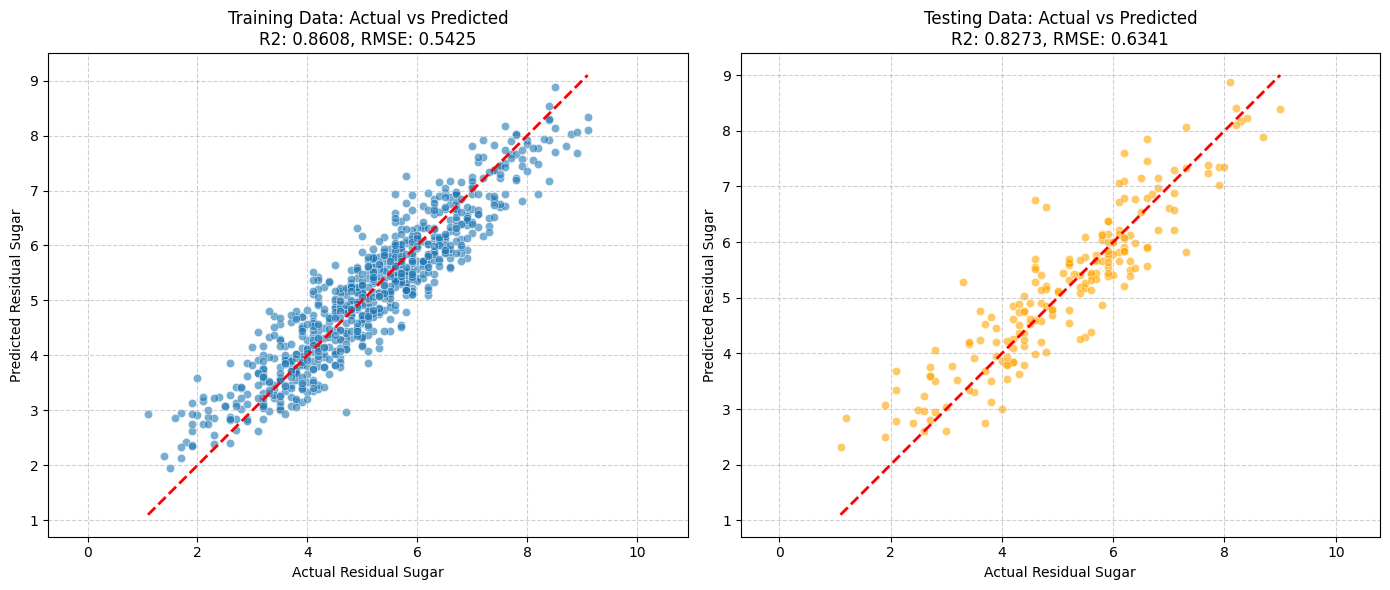

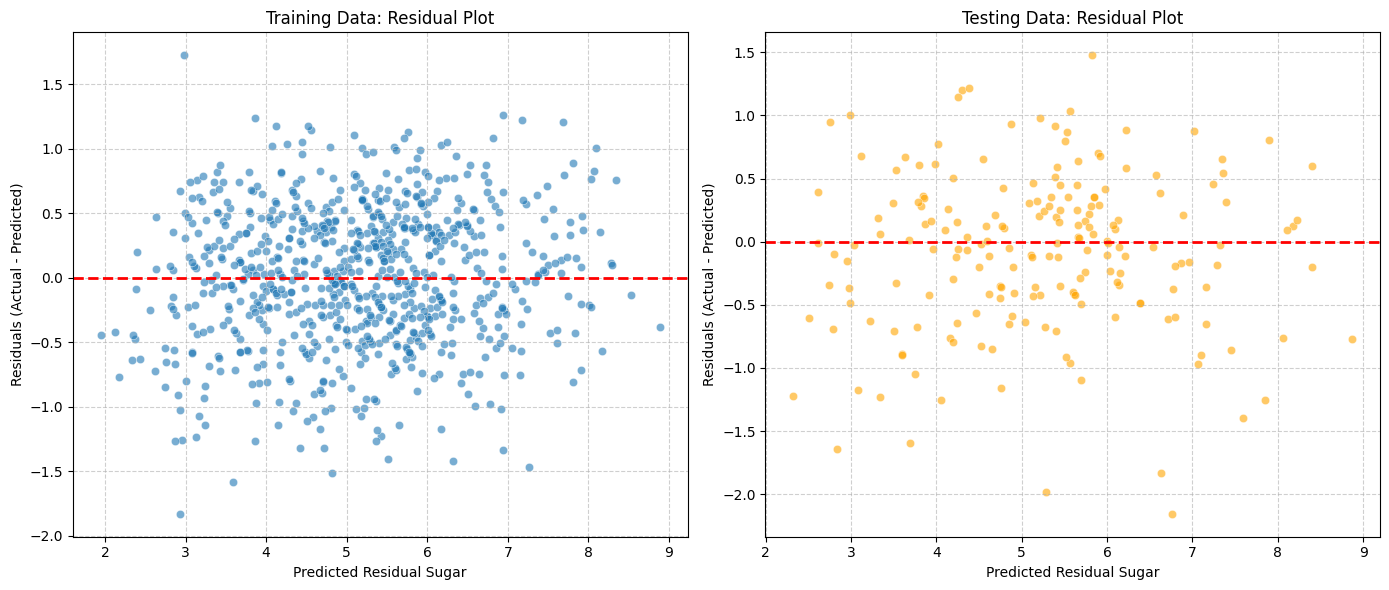

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming best_model, X_train, X_test, y_train, y_test are already defined

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate R2 and RMSE
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))

# Training Data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.title(f'Training Data: Actual vs Predicted\nR2: {r2_train:.4f}, RMSE: {rmse_train:.4f}')
plt.xlabel('Actual Residual Sugar')
plt.ylabel('Predicted Residual Sugar')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensure equal scaling

# Testing Data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Testing Data: Actual vs Predicted\nR2: {r2_test:.4f}, RMSE: {rmse_test:.4f}')
plt.xlabel('Actual Residual Sugar')
plt.ylabel('Predicted Residual Sugar')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensure equal scaling

plt.tight_layout()
plt.show()

# --- Plot Residuals ---
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(14, 6))

# Training Residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_pred, y=train_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Training Data: Residual Plot')
plt.xlabel('Predicted Residual Sugar')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)

# Testing Residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_pred, y=test_residuals, alpha=0.6, color='orange')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Testing Data: Residual Plot')
plt.xlabel('Predicted Residual Sugar')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

| Step                | What It Checks          | Why Important                            |
| ------------------- | ----------------------- | ---------------------------------------- |
| R² & RMSE           | Quantitative accuracy   | Measures model fit numerically           |
| Actual vs Predicted | Overall correctness     | Checks if predictions align with reality |
| Residual Plot       | Bias or missed patterns | Detects systematic model errors          |

You’re not just seeing how much the model got right — you’re checking how it got things wrong, and whether those mistakes are random or systematic.

1️⃣ *The model makes predictions*
* It guesses the output (Residual Sugar) for both the training data and unseen testing data.

2️⃣ *We calculate accuracy numbers*
* R² tells how well the model fits (closer to 1 = better).
* RMSE tells how big the prediction errors are (smaller = better).

3️⃣ *We draw two graphs*

First graph: compares actual vs predicted values.
* If points are close to the red line, predictions are good.

Second graph: shows residuals (errors).
* If dots are scattered randomly around zero, model is fine.
* If you see a pattern, model missed something

## Save final model

**Prompt:**

Save the best model in pickle format

In [1]:
import pickle

# Define the filename of the pickled model
filename = 'best_xgboost_model.pkl'

# Load the model from the file
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

print(f"Model loaded successfully from '{filename}'")

# You can now use 'loaded_model' for predictions or further analysis
# For example, to make a prediction:
# loaded_model.predict(...)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import pickle

# Assuming best_model is already defined from previous steps

# Define the filename for the pickled model
filename = 'best_xgboost_model.pkl'

# Save the model to the specified file using pickle
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved successfully as '{filename}'")

Best model saved successfully as 'best_xgboost_model.pkl'


# Model Explanation with XAI


**SHAP (SHapley Additive exPlanations)**

![shap](./assets/shap.png)

**Prompt:**

I trained an xgboost model. Features are 'Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration'. Using Shap, give me the code for feature importance plot and dependency plots.

Model name: best_model, use X_train data


Generating SHAP Feature Importance Plot...


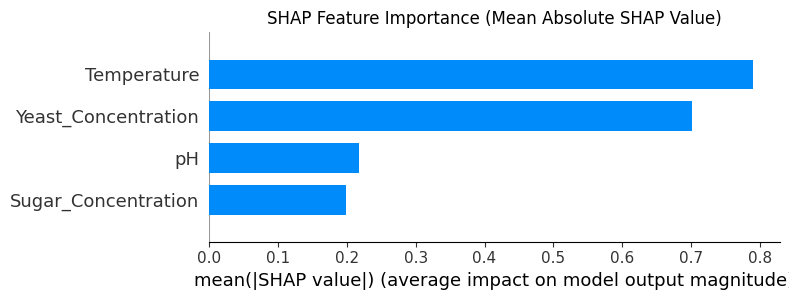


Generating SHAP Summary Plot (Distribution)...


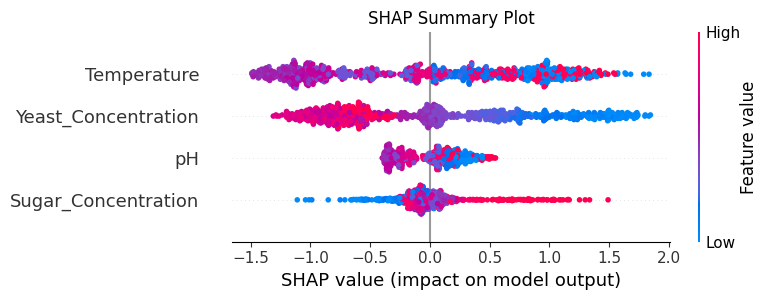


Generating SHAP Dependency Plots...
Generating Dependency Plot for Temperature...


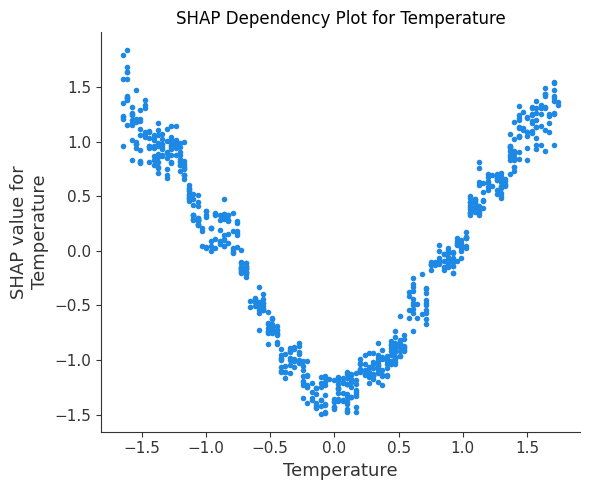

Generating Dependency Plot for pH...


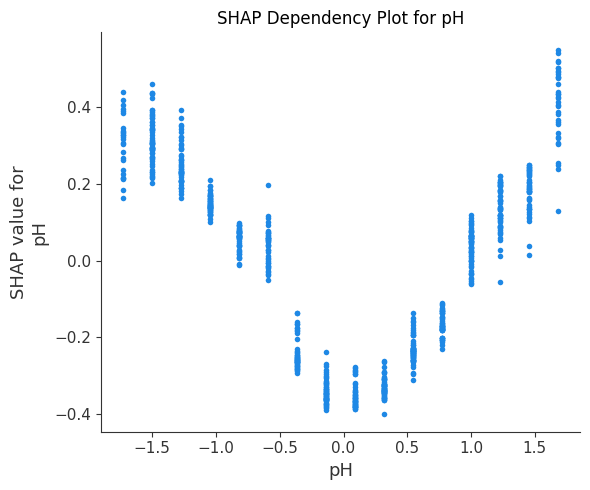

Generating Dependency Plot for Yeast_Concentration...


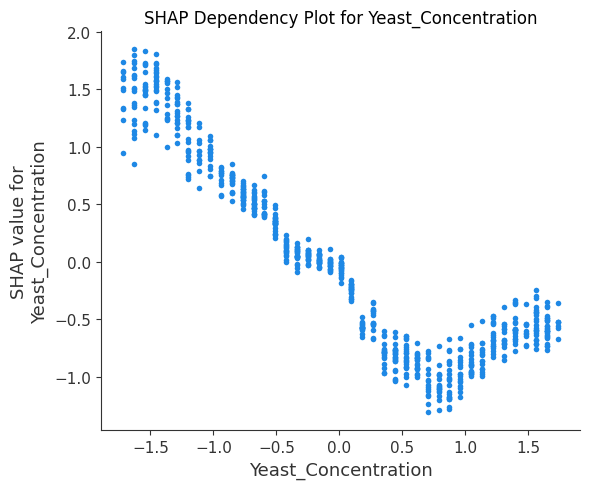

Generating Dependency Plot for Sugar_Concentration...


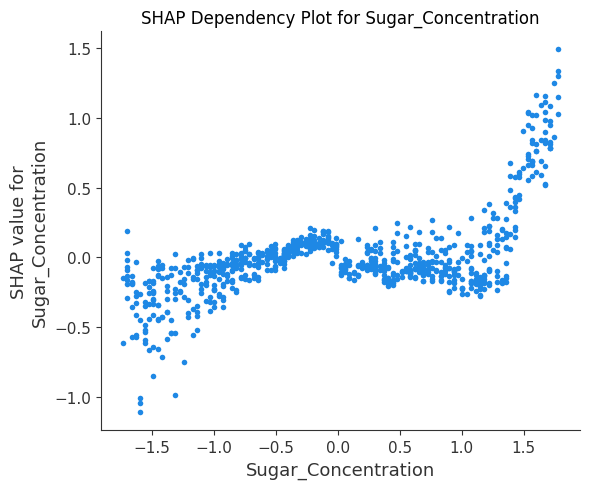


SHAP plots generated.


In [ ]:
# Install shap if not already installed
!pip install shap

import shap
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for DataFrame

# Assuming best_model and X_train are already defined from previous steps
# Create a SHAP Tree explainer for the XGBoost model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the training data
# Ensure X_train is a pandas DataFrame for better plotting with column names
if not isinstance(X_train, pd.DataFrame):
    # Assuming the original feature names are in the 'features' list
    X_train_df = pd.DataFrame(X_train, columns=features)
else:
    X_train_df = X_train

shap_values = explainer.shap_values(X_train_df)

# --- SHAP Feature Importance Plot (Summary Plot) ---
print("Generating SHAP Feature Importance Plot...")
shap.summary_plot(shap_values, X_train_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()

print("\nGenerating SHAP Summary Plot (Distribution)...")
shap.summary_plot(shap_values, X_train_df, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# --- SHAP Dependency Plots ---
print("\nGenerating SHAP Dependency Plots...")
# Generate a dependency plot for each feature
for feature_name in features:
    print(f"Generating Dependency Plot for {feature_name}...")
    shap.dependence_plot(feature_name, shap_values, X_train_df, interaction_index=None, show=False)
    plt.title(f"SHAP Dependency Plot for {feature_name}")
    plt.tight_layout()
    plt.show()

print("\nSHAP plots generated.")

SHAP Summary Plot
| Feature                 | Red dots mostly on... | Interpretation                                          |
| ----------------------- | --------------------- | ------------------------------------------------------- |
| **Sugar_Concentration** | Right                 | High sugar increases predicted residual sugar           |
| **Yeast_Concentration** | Left                  | High yeast decreases residual sugar (it consumes sugar) |
| **Temperature**         | Right                 | High temperature helps sugar remain (positive effect)   |
| **pH**                  | Mixed both sides      | No strong linear relation; depends on other features    |

So visually:
* Top features = most influential.
* Color direction = correlation type (positive/negative).
* Spread = how strong or variable the effect is.

⚡ Quick mental shortcut:

Left = decreases prediction,
Right = increases prediction,
Color = value of feature,
Top = most important features.

# Optimization

![opt](./assets/optimization.jpg)

**Stage 1 – Wide search (cheap, covers space)**

- Coarse grid
- Random search
- Few iterations of BayesOpt

Select top candidates:
- Sort results by predicted Residual_Sugar
- Pick top N
- Ensure they are not clustered (can use a distance filter)

**Stage 2 – Multiple BayesOpt refinements**

For each candidate:

- Define a local search box ±δ around its values
- Run a narrow Bayesian optimization in that box

Compare the refined minima from each candidate and pick the overall best.

**Prompt:**
Using two stage optimization (multicandidate for wide and Bayesian for narrow), find the optimum feature values to minimize target..features = ['Temperature', 'pH', 'Yeast_Concentration', 'Sugar_Concentration'] target = 'Residual_Sugar'

Parameter range:
    'Temperature': 25 to 35°C
    'pH': 4.0 to 5.5
    'Yeast_Concentration': 1 to 5 g/L
    'Sugar_Concentration': 10 to 20% w/v

| Step    | What it does                                         | Analogy                                               |
| ------- | ---------------------------------------------------- | ----------------------------------------------------- |
| Stage 1 | Tests many combinations roughly                      | Looking around the whole city for a good neighborhood |
| Stage 2 | Focuses near the best ones and fine-tunes            | Searching specific streets for the perfect house      |
| Result  | Best combination of inputs for lowest Residual Sugar | The exact “address” where you get the best outcome    |


In [ ]:
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler # Assuming StandardScaler was used for training

# Assuming best_model and scaler are already defined from previous steps
# Assuming features list is also defined

# Define the objective function to minimize (predict Residual_Sugar)
# The function needs to take the raw feature values as input, scale them, and then use the model to predict
def objective_function(params):
    # Convert the parameters (list) to a pandas DataFrame with correct column names
    # This is necessary because the scaler expects a DataFrame or array with consistent feature order
    params_df = pd.DataFrame([params], columns=features)

    # Scale the input parameters using the same scaler used for training
    # Ensure that the scaler is fitted before this step
    params_scaled = scaler.transform(params_df)

    # Predict the residual sugar using the best model
    predicted_residual_sugar = best_model.predict(params_scaled)[0] # Get the first element as predict returns an array

    return predicted_residual_sugar

# Define the bounds for the optimization based on the user's specified ranges
bounds = [
    (25, 35),  # Temperature
    (4.0, 5.5), # pH
    (1, 5),    # Yeast_Concentration
    (10, 20)   # Sugar_Concentration
]

# Convert bounds to skopt.space.Real format for gp_minimize
dimensions = [Real(low=lower, high=upper, name=features[i]) for i, (lower, upper) in enumerate(bounds)]

# --- Stage 1: Wide Search (using gp_minimize with multiple initial points) ---
print("--- Stage 1: Wide Search (using gp_minimize) ---")

# Number of initial points for the wide search
n_initial_points = 10
# Number of total calls for the wide search (including initial points)
n_calls_wide = 50

wide_search_results = gp_minimize(
    func=objective_function,
    dimensions=dimensions,
    n_calls=n_calls_wide,
    n_initial_points=n_initial_points,
    random_state=42,
    noise='gaussian', # Assuming some noise in the objective
    verbose=True
)

# Get the location and value of the best point from the wide search
best_location_wide = wide_search_results.x
best_value_wide = wide_search_results.fun

print(f"\nWide Search Best Result:")
print(f"  Optimal Feature Values: {dict(zip(features, best_location_wide))}")
print(f"  Predicted Minimum Residual Sugar: {best_value_wide:.4f}")

# --- Stage 2: Multiple BayesOpt Refinements (around top candidates from wide search) ---
print("\n--- Stage 2: Multiple BayesOpt Refinements ---")

# Identify top candidates from the wide search results
# Sort the results by function value (predicted residual sugar) and select top N
# You might want to add a check for diversity among top candidates if needed
top_n_candidates = 5 # Number of top candidates to refine

# Get the indices that would sort the results by function value
sorted_indices = np.argsort(wide_search_results.func_vals)

# Select the top N candidate locations
top_candidate_locations = [wide_search_results.x_iters[i] for i in sorted_indices[:top_n_candidates]]

refined_results = []

# Define the local search box size (delta)
delta = 0.5 # Adjust delta based on the scale of your features

for i, candidate_location in enumerate(top_candidate_locations):
    print(f"\nRefining around Candidate {i+1}: {dict(zip(features, candidate_location))}")

    # Define local bounds around the candidate location
    local_bounds = [
        (max(bounds[j][0], candidate_location[j] - delta), min(bounds[j][1], candidate_location[j] + delta))
        for j in range(len(features))
    ]

    # Convert local bounds to skopt.space.Real format
    local_dimensions = [Real(low=lower, high=upper, name=features[j]) for j, (lower, upper) in enumerate(local_bounds)]

    # Run a narrow Bayesian optimization in the local search box
    n_calls_narrow = 20 # Number of calls for narrow search per candidate

    local_search_result = gp_minimize(
        func=objective_function,
        dimensions=local_dimensions,
        n_calls=n_calls_narrow,
        n_initial_points=5, # Use a few initial points in the local region
        random_state=42 + i, # Use different random state for each refinement
        noise='gaussian',
        verbose=False # Set to True for more detailed output during refinement
    )

    refined_results.append({
        'candidate': i+1,
        'location': local_search_result.x,
        'value': local_search_result.fun
    })

# Find the overall best result from the refined searches
overall_best_result = min(refined_results, key=lambda x: x['value'])

print("\n--- Optimization Complete ---")
print("Overall Best Result found after refinements:")
print(f"  Optimal Feature Values: {dict(zip(features, overall_best_result['location']))}")
print(f"  Predicted Minimum Residual Sugar: {overall_best_result['value']:.4f}")

# You can further analyze the refined_results list if needed

--- Stage 1: Wide Search (using gp_minimize) ---
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0102
Function value obtained: 4.6292
Current minimum: 4.6292
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0062
Function value obtained: 4.1895
Current minimum: 4.1895
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0026
Function value obtained: 7.6291
Current minimum: 4.1895
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0019
Function value obtained: 6.0339
Current minimum: 4.1895
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0022
Function value obtained: 5.8781
Current mi

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00
